In [1]:
import sys
sys.path.append('..')

from olfactory_navigation import Environment, Agent
from olfactory_navigation.agents import FSVI_Agent
from olfactory_navigation.simulation import run_test, SimulationHistory
from olfactory_navigation.test_setups import run_all_starts_test

from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import cupy as cp

In [2]:
from cupy.cuda import runtime as cuda_runtime
cuda_runtime.setDevice(0)

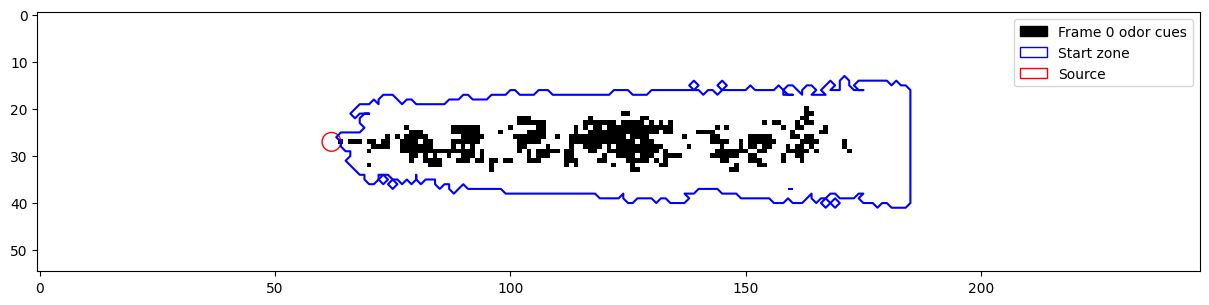

In [3]:
# data_path = "/storage/rando/data/nose_data_27_123.npy" # INSERT YOUR PATH
data_path = "G:\\My Drive\\Documents\\Universita di Genova\\Pimlb work\\nose_data_27_123.npy"

env = Environment(data_file=data_path,
                  data_source_position=[13, 0],
                  source_radius=2,
                  margins=[14, 62],
                  boundary_condition='wrap_vertical',
                  start_zone='odor_present',
                  odor_present_threshold=3e-6)

env.plot()

In [4]:
from olfactory_navigation.agents.model_based_util.pomdp import Model

def minimal_converter(environment: Environment,
                      threshold: float | list,
                      partitions: np.ndarray = np.array([1,3])
                      ) -> Model:
    '''
    '''
    # Getting probabilities of odor in the requested partitions
    y_partitions = partitions[0]
    x_partitions = partitions[1]

    cell_shape = (environment.data_shape / np.array([y_partitions, x_partitions])).astype(int)
    cell_odor_probs = np.zeros((y_partitions, x_partitions))

    for y_i in range(y_partitions):
        for x_i in range(x_partitions):
            cell = environment.data[:,
                                    (y_i * cell_shape[0]) : ((y_i + 1) * cell_shape[0]),
                                    (x_i * cell_shape[1]) : ((x_i + 1) * cell_shape[1])]

            cell_odor_probs[y_i, x_i] = np.average(cell > threshold)

    odor_probabilities = np.zeros(((y_partitions + 2), (x_partitions + 3)))
    odor_probabilities[1:-1,2:-1] = cell_odor_probs

    # General attributes
    state_count = np.prod(odor_probabilities.shape)
    shape = odor_probabilities.shape

    # State grid
    state_grid = [[f's_{x}_{y}' for x in range(shape[1])] for y in range(shape[0])]

    # Transition probabilities of the model
    width = shape[1]
    transition_probabilities = np.zeros((state_count, 4, state_count))

    move_out_prob = 1/cell_shape
    # move_out_prob = [0.01,0.01]

    for y in range(shape[0]):
        for x in range(shape[1]):

            # North
            if y == 0:
                transition_probabilities[(y * width) + x, 0, (y * width) + x] = 1.0
            else:
                transition_probabilities[(y * width) + x, 0, (y * width) + x] = (1 - move_out_prob[0])
                transition_probabilities[(y * width) + x, 0, ((y - 1) * width) + x] = move_out_prob[0]

            # East
            if x == (shape[1] - 1):
                transition_probabilities[(y * width) + x, 1, (y * width) + x] = 1.0
            else:
                transition_probabilities[(y * width) + x, 1, (y * width) + x] = (1 - move_out_prob[1])
                transition_probabilities[(y * width) + x, 1, (y * width) + (x + 1)] = move_out_prob[1]
            
            # South
            if y == (shape[0] - 1):
                transition_probabilities[(y * width) + x, 2, (y * width) + x] = 1.0
            else:
                transition_probabilities[(y * width) + x, 2, (y * width) + x] = (1 - move_out_prob[1])
                transition_probabilities[(y * width) + x, 2, ((y + 1) * width) + x] = move_out_prob[1]

            # West
            if x == 0:
                transition_probabilities[(y * width) + x, 3, (y * width) + x] = 1.0
            else:
                transition_probabilities[(y * width) + x, 3, (y * width) + x] = (1 - move_out_prob[0])
                transition_probabilities[(y * width) + x, 3, (y * width) + (x - 1)] = move_out_prob[0]

    # Goal states
    end_states = [(1 * width) + 1]

    # Observations
    observation_labels = ['nothing', 'something', 'goal']

    observations = np.zeros((state_count, 4, len(observation_labels)))

    observations[:, :, 0] = (1 - odor_probabilities.flatten())[:,None]
    observations[:, :, 1] = odor_probabilities.flatten()[:,None]

    observations[end_states, :, -1] = 0.0
    observations[end_states, :, :] = 0.0
    observations[end_states, :, -1] = 1.0

    # Start probabilities
    start_probabilities = np.ones(state_count, dtype=float)
    # start_probabilities = (odor_probabilities > 0).astype(float).flatten()
    start_probabilities /= np.sum(start_probabilities)

    # Creation of the Model
    model = Model(
        states = state_grid,
        actions = ['N','E','S','W'],
        observations = observation_labels,
        transitions = transition_probabilities,
        observation_table = observations,
        end_states = end_states,
        start_probabilities = start_probabilities
    )

    return model

In [5]:
ag = FSVI_Agent(env, environment_converter=minimal_converter)

In [6]:
_ = ag.train(expansions=1000, force=True, use_gpu=True)

[06/13/2024, 21:31:13] MDP_policy, not provided. Solving MDP with Value Iteration...
[06/13/2024, 21:31:13] Sending Model to GPU...
[06/13/2024, 21:31:14]     > Done in 0.945s


  0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 18-state, 4-action
  - Converged in 868 iterations and 3.6008 seconds
  - Took on average 0.0041s per iteration


Expansions:   0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Point Based Value Iteration run
  - Model: 18 state, 4 action, 3 observations
  - Converged or stopped after 1000 expansion steps and 1000 backup steps.
  - Resulting value function has 5081 alpha vectors.
  - Converged in 49.9893s

  - Expand function took on average 0.0351s and yielded on average 315.86 beliefs per iteration. (0.0009s/it/belief)
  - Backup function took on average 0.0149s and yielded on average 5.08 alpha vectors per iteration. (0.0005s/it/alpha)
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


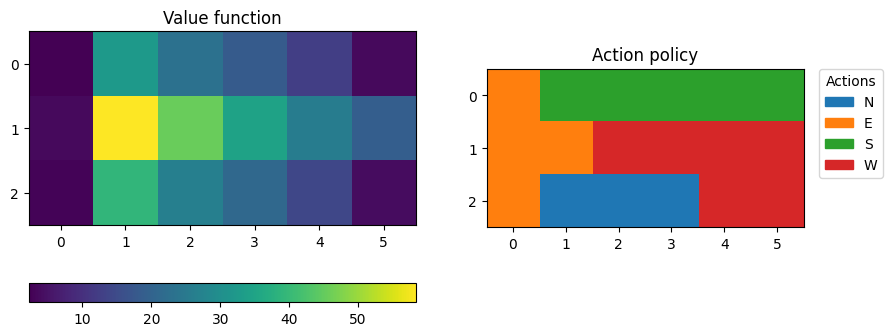

In [7]:
ag.value_function.plot()

In [8]:
hist = run_all_starts_test(ag, use_gpu=True)


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulations done in 34.337s:
Simulations reached goal: 772/2393 (1621 failures (reached horizon: 1621)) (32.26% success)
 - Average step count:                 711.552 +- 422.95 (Successfull only: 105.887 +- 113.96)
 - Extra steps:                        640.519 +- 418.09 (Successful only: 41.602 +- 100.36)
 - Average discounted rewards (ADR):   0.156 +- 0.27 (Successfull only: 0.484 +- 0.25)
 - Tmin/T:                             0.315 +- 0.38 (Successful only: 0.821 +- 0.27)


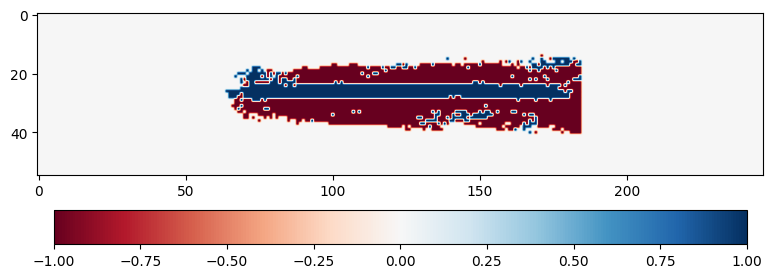

In [9]:
start_points_grid = np.zeros(env.shape)

failed_points = hist.start_points[hist.done_at_step == -1]
success_points = hist.start_points[hist.done_at_step != -1]

start_points_grid[failed_points[:,0], failed_points[:,1]] = -1
start_points_grid[success_points[:,0], success_points[:,1]] = 1

plt.figure(figsize=(10,3))
plt.imshow(start_points_grid, cmap='RdBu')
plt.colorbar(orientation='horizontal')

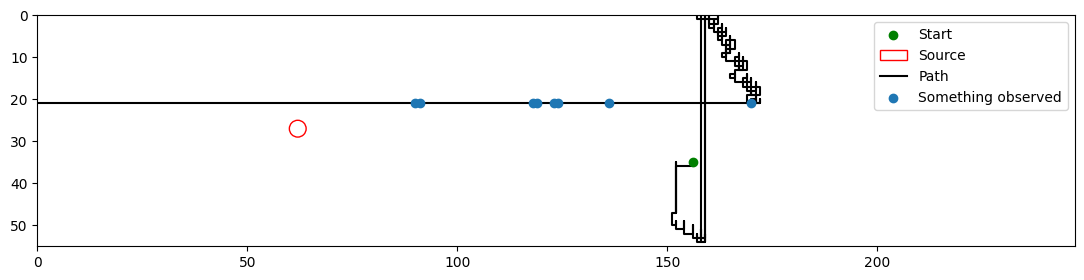

In [21]:
hist.plot(2111)